# Анализ журнала обнаружения вторжений

Данный датасет содержит синтетические логи работы сети, симулирующие нормальную и вредоносную активность за недельный период.

Главные цель данного исследования:
- классифицировать тип запроса: нормальный, сканирование портов или бот-атака.

Задачи:
- провести разведочный анализ данных;
- при необходимости очистить данные, преобразовать и создать новые параметры;
- разделить данные на тренировочную и тестовую выборки (при необходимости провести кросс-валидацию);
- на основе имеющихся данных выбрать один или несколько алгоритмов;
- выбрать гиперпараметры для алгоритмов;
- обучить модели на тренировочных данных;
- оценить качество моделей, выбрать среди них наиболее хорошо обобщающую новые данные;
- выпить чашечку чая и завершить свой первый ML-проект на GitHub.


Ссылка: https://www.kaggle.com/datasets/developerghost/intrusion-detection-logs-normal-bot-scan

## Импорт библиотек и модулей

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import TargetEncoder, LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

## Загрузка данных

In [2]:
logs = pd.read_csv("Network_logs.csv")
print(f"Первые 5 строк датасета:\n\n{logs.head()}\n")
print(f"Последние 5 строк датасета:\n\n{logs.tail()}")

Первые 5 строк датасета:

        Source_IP  Destination_IP  Port Request_Type Protocol  Payload_Size  \
0  192.168.142.55   42.156.67.167    80          FTP      UDP          2369   
1    53.39.165.18   94.60.242.119   135         SMTP      UDP          1536   
2  192.168.127.91      7.10.192.3    21         SMTP      TCP          1183   
3   192.168.30.40  130.169.82.211    25        HTTPS      TCP           666   
4  192.168.43.179  35.140.102.220    22          FTP      TCP          2821   

    User_Agent   Status  Intrusion  Scan_Type  
0  curl/7.68.0  Success          0     Normal  
1  Wget/1.20.3  Failure          1  BotAttack  
2  Wget/1.20.3  Success          0     Normal  
3  Mozilla/5.0  Success          0     Normal  
4  Mozilla/5.0  Success          0     Normal  

Последние 5 строк датасета:

            Source_IP   Destination_IP   Port Request_Type Protocol  \
8841   192.168.62.111    217.201.54.87     22          DNS      UDP   
8842   192.168.154.70    11.93.131.139 

## Разведочный анализ данных
Датасет имеет 8846 строк и 10 столбцов с отсутствующими null-значениями, что несколько упрощает очистку датасета. Имеются следующие столбцы:
- Source_IP - IP-адрес источника запроса;
- Destination_IP - IP-адрес получателя запроса;
- Port - Порт;
- Request_Type - Протокол прикладного уровня;
- Protocol - Протокол нижестоящих уровней (Транспортный/сетевой);
- Payload_Size - Нагрузка;
- User_Agent - User-Agent отправителя;
- Status - Статус запроса (Успех/Провал);
- Intrussion - Отметка попытки вторжения;
- Scan_Type - Совершаемое действие (Обычное/Сканирование портов/Атака ботов)

In [3]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8846 entries, 0 to 8845
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Source_IP       8846 non-null   object
 1   Destination_IP  8846 non-null   object
 2   Port            8846 non-null   int64 
 3   Request_Type    8846 non-null   object
 4   Protocol        8846 non-null   object
 5   Payload_Size    8846 non-null   int64 
 6   User_Agent      8846 non-null   object
 7   Status          8846 non-null   object
 8   Intrusion       8846 non-null   int64 
 9   Scan_Type       8846 non-null   object
dtypes: int64(3), object(7)
memory usage: 691.2+ KB


Целевой переменной в данном случае является:
- **Scan_Type** - категориальная переменная, классифицирующая нормальные ли был запрос или являлся вредоносным (BotAttack/PortScan).

### Проанализируем целевую переменную

Посмотрим на соотношение обычных и вредоносных запросов, на количество успешных и провальных запросов, а также на количество успешных и провальных среди обычных запросов и вредоносных запросов. 

In [32]:
intrusion_counts = logs['Intrusion'].value_counts()
status_counts = logs['Status'].value_counts()

intrusion_statuses = pd.DataFrame()

for i, col_name in enumerate(['Common', 'Malicious']):
    col = logs[(logs['Intrusion'] == i) & ((logs['Status'] == 'Success') | (logs['Status'] == 'Failure'))]
    intrusion_statuses.insert(i, col_name, col['Status'].value_counts())
    
print(f"Соотношение нормальных и вредоносных запросов:\n{intrusion_counts}\n")
print(f"Соотношение успешных и провальных запросов:\n{status_counts}\n")
print(f"Соотношение успешных и провальных нормальных запросов:\n{intrusion_statuses['Common']}\n")
print(f"Соотношение успешных и провальных вредоносных запросов:\n{intrusion_statuses['Malicious']}\n")

Соотношение нормальных и вредоносных запросов:
Intrusion
0    8000
1     846
Name: count, dtype: int64

Соотношение успешных и провальных запросов:
Status
Success    7737
Failure    1109
Name: count, dtype: int64

Соотношение успешных и провальных нормальных запросов:
Status
Success    7615
Failure     385
Name: Common, dtype: int64

Соотношение успешных и провальных вредоносных запросов:
Status
Success    122
Failure    724
Name: Malicious, dtype: int64



В результате видим, что из всего количества запросов:
- 8000 (90,44%) являются нормальными;
- 846 (9,56%) запросов являются вредоносными;
- 7737 (87,46%) являются успешными;
- 1109 (12,54%) являются провальными.

Среди нормальных запросов:
- 7615 (95,19%) являются успешными;
- 385 (4,81%) являются провальными.

Среди вредоносных запросов:
- 122 (14,42%) являются успешными;
- 724 (85,58%) являются провальными.

Какие выводы мы модет из этого сделать:
- Среди обычных запросов большая часть являются успешными, а среди  вредоносных, наоборот, больше провальных запросов.
- Можно предположить, что признак "Status" можно использовать для нашей модели.

Построим столбчатую диаграмму для визуализации полученных соотношений.

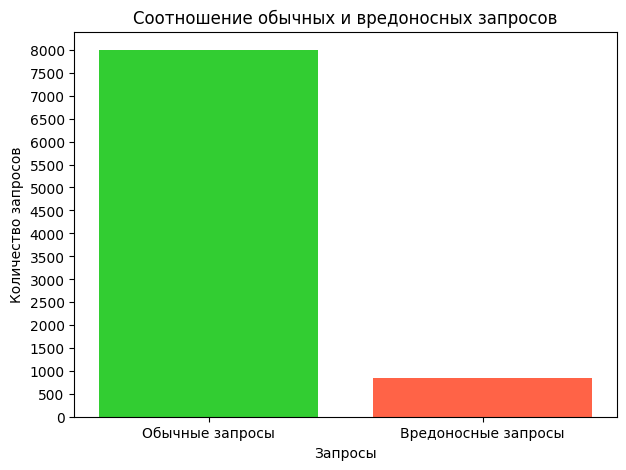

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

ax.bar(['Обычные запросы', 'Вредоносные запросы'], intrusion_counts, 
          color=['limegreen', 'tomato'])
ax.set_yticks(np.arange(0, np.max(intrusion_counts)+500, 500))
ax.set_title('Соотношение обычных и вредоносных запросов')
ax.set_xlabel('Запросы')
ax.set_ylabel('Количество запросов')
plt.show()

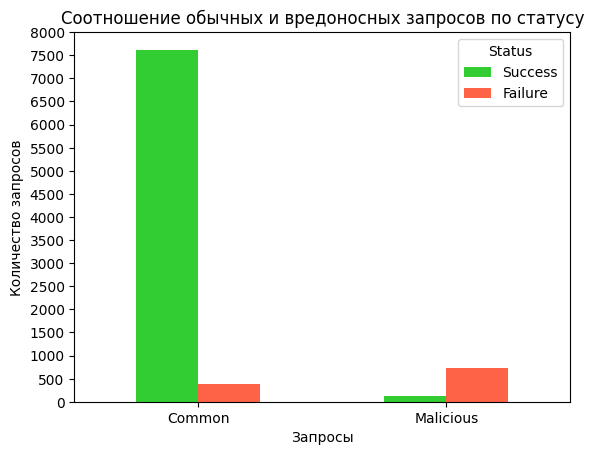

In [37]:
ax = intrusion_statuses.T.plot.bar(rot=0, color=['limegreen', 'tomato'])
ax.set_title('Соотношение обычных и вредоносных запросов по статусу')
ax.set_xlabel('Запросы')
ax.set_ylabel('Количество запросов')
ax.set_yticks(np.arange(0, np.max(intrusion_counts)+500, 500))
plt.show()

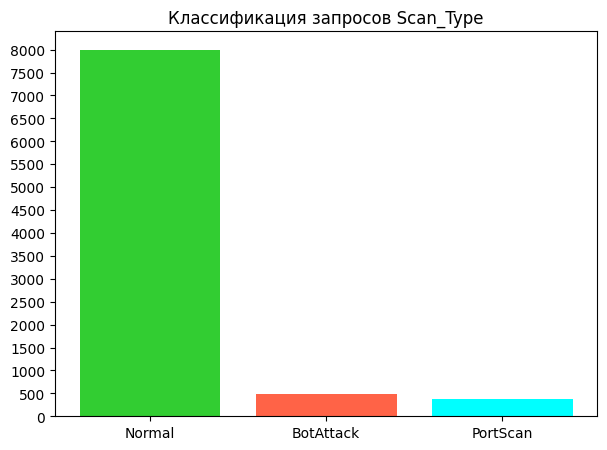

In [39]:
scan_types = logs['Scan_Type'].value_counts()

fig, ax = plt.subplots(figsize=(7, 5))

ax.bar(scan_types.index, scan_types.values, color=['limegreen', 'tomato', 'cyan'])
ax.set_title('Классификация запросов Scan_Type')
ax.set_yticks(np.arange(0, max(scan_types)+500, 500))
plt.show()

Не лишним будет проверить, нет ли в датасете ошибок, когда признак 'Intrusion' равен 0 (т.е. запрос нормальный), а 'Scan_Type' классифицируется, как BotAttack или PortScan.

In [8]:
print(f"Уникальные значения Scan_Type при Intrusion=0: {logs[logs['Intrusion'] == 0]['Scan_Type'].unique()}")
print(f"Уникальные значения Scan_Type при Intrusion=1: {logs[logs['Intrusion'] == 1]['Scan_Type'].unique()}")

Уникальные значения Scan_Type при Intrusion=0: ['Normal']
Уникальные значения Scan_Type при Intrusion=1: ['BotAttack' 'PortScan']


Следует отметить, что признак 'Intrusion' классифицирует запросы на нормальные и вредоносным. При этом целевая переменная 'Scan_Type' так же классифицирует запросы на нормальные и вредоносные, но более детально. Таким образом, когда признак 'Intrusion' будет равен 1, 'Scan_Type' будет просто классифицировать этот вредоносный запрос. **Это говорит о взаимосвязи признака 'Intrusion' и переменной 'Scan_Type', что может являться причиной для исключения Intrusion из набора признаков для обучения модели.**

### Проанализируем IP-адреса отправителей и получателей.

Сами по себе IP-адреса отправителей не являются ценным признаком по следующим причинам:
- **IP-адрес является просто идентификатором устройства в сети, его случайное значение никак не влияет на признак и характер атаки;**
- **IP-адрес атакующего устройства может быть абсолютно любым;**
- **IP-адреса можно менять.**

По этим причинам нет смысла включать 'Source_IP' в список признаков.

IP-адреса получателей так же не является полезным признаком:
- **Атаки могут происходить на разные ресурсы;**
- **IP-адрес не даёт информации о характере атаки и не может быть использован для прогнозирования;**
- **Единственной полезной информацией может быть количество атак на определённые ресурсы.**

In [9]:
for i in [0, 1]:
    print(f"Количество запросов по IP-адресам с Intrusion={i}:\n{logs[logs['Intrusion']==i]['Source_IP'].value_counts().head(10)}\n")

Количество запросов по IP-адресам с Intrusion=0:
192.168.108.150    3
192.168.91.48      3
192.168.147.188    3
192.168.124.233    3
192.168.86.173     3
192.168.50.207     3
192.168.166.28     3
192.168.231.128    3
192.168.224.142    3
192.168.33.4       3
Name: Source_IP, dtype: int64

Количество запросов по IP-адресам с Intrusion=1:
33.5.52.172        58
154.113.2.100      57
95.139.88.51       57
78.199.98.120      56
197.134.233.238    54
94.40.34.8         48
201.232.85.16      46
216.181.134.4      46
161.77.134.239     45
219.110.174.163    44
Name: Source_IP, dtype: int64



In [10]:
print(f"Наиболее атакуемые ресурсы:\n{logs[logs['Intrusion']==1]['Destination_IP'].value_counts().sort_values(ascending=False)}")

Наиболее атакуемые ресурсы:
94.60.242.119      1
78.142.23.114      1
159.108.69.64      1
171.149.47.196     1
146.171.223.16     1
                  ..
11.88.20.176       1
195.180.238.190    1
211.139.148.189    1
187.227.223.149    1
168.101.218.238    1
Name: Destination_IP, Length: 846, dtype: int64


Как видно, среди адресов назначения не выделяются конкретные IP-адреса, следовательно данный столбец так же не несёт полезной информации.
Оба столбца можно исключить из набора признаков.

### Проанализируем порты, протоколы прикладного, протоколы нижестоящих уровней и User-Agent'ы

Выведем уникальные значения по столбцам для каждого признака. После чего посмотрим на порты, протоколы и user-agents при различных значениях признака запросов: Normal, BotAttack и PortScan.

In [20]:
list_of_features = ['Port', 'Request_Type', 'Protocol', 'User_Agent']

for col in list_of_features:
    print(f"Уникальные значения столбца {col}:\n{logs[col].unique()}\n")

Уникальные значения столбца Port:
[   80   135    21    25    22    53   443  4444  6667    23 31337  8080]

Уникальные значения столбца Request_Type:
['FTP' 'SMTP' 'HTTPS' 'DNS' 'SSH' 'HTTP' 'Telnet']

Уникальные значения столбца Protocol:
['UDP' 'TCP' 'ICMP']

Уникальные значения столбца User_Agent:
['curl/7.68.0' 'Wget/1.20.3' 'Mozilla/5.0' 'Nikto/2.1.6' 'nmap/7.80'
 'python-requests/2.25.1']



In [12]:
for feature in list_of_features:
    normal_values = logs[logs['Scan_Type'] == 'Normal'][feature].unique()
    bot_attack_values = logs[logs['Scan_Type'] == 'BotAttack'][feature].unique()
    port_scan_values = logs[logs['Scan_Type'] == 'PortScan'][feature].unique()
    
    print(f"Значения признака {feature} при Normal: {sorted(normal_values)}")
    print(f"Значения признака {feature} при BotAttack: {sorted(bot_attack_values)}")
    print(f"Значения признака {feature} при PortScan: {sorted(port_scan_values)}\n")

Значения признака Port при Normal: [21, 22, 25, 53, 80, 443]
Значения признака Port при BotAttack: [23, 135, 4444, 6667, 8080, 31337]
Значения признака Port при PortScan: [23, 135, 4444, 6667, 8080, 31337]

Значения признака Request_Type при Normal: ['DNS', 'FTP', 'HTTP', 'HTTPS', 'SMTP', 'SSH', 'Telnet']
Значения признака Request_Type при BotAttack: ['DNS', 'FTP', 'HTTP', 'HTTPS', 'SMTP', 'SSH', 'Telnet']
Значения признака Request_Type при PortScan: ['DNS', 'FTP', 'HTTP', 'HTTPS', 'SMTP', 'SSH', 'Telnet']

Значения признака Protocol при Normal: ['ICMP', 'TCP', 'UDP']
Значения признака Protocol при BotAttack: ['ICMP', 'TCP', 'UDP']
Значения признака Protocol при PortScan: ['ICMP', 'TCP', 'UDP']

Значения признака User_Agent при Normal: ['Mozilla/5.0', 'Nikto/2.1.6', 'Wget/1.20.3', 'curl/7.68.0', 'nmap/7.80', 'python-requests/2.25.1']
Значения признака User_Agent при BotAttack: ['Mozilla/5.0', 'Nikto/2.1.6', 'Wget/1.20.3', 'curl/7.68.0', 'nmap/7.80', 'python-requests/2.25.1']
Значения п

Из этого мы можем сделать некоторые полезные выводы:
- **Порты при атаке ботов и сканировании портов - одинаковые;**
- **Протоколы и User-Agent'ы при нормальных запросах, атаке ботов и сканировании портов - одинаковые.**

Построим столбчатые диаграммы, показывающие количество запросов и их тип атаки по признакам Request_Type, Protocol и User_Agent.

In [27]:
def create_feature_dict(feature, outcomes):
    """Функция для создания словаря:
    Key - Тип атаки (Normal, BotAttack, PortScan)
    Value - Количество запросов по типу атаки для значений определённого признака
    Например: BotAttack: [10, 22, 12] - количество запросов по протоколу ICMP, TCP, UDP при бот-атаке"""
    
    feature_labels = logs[feature].unique()  # Метки иксов
    feature_labels.sort()  # сортировка меток иксов для схождения с количествами запросов, сортированных по индексу
    request_by_scan_type = {key: None for key in outcomes}  # Словарь исход: количество запросов
    
    for key in request_by_scan_type:
        
        value_counts_list = logs[logs['Scan_Type'] == key][feature].value_counts().sort_index().values  # сортированный по индексу список с количествами запросов
        request_by_scan_type[key] = value_counts_list  # добавляем количество запросов к типу исхода (Normal, BotAttack, PortScan)
        
        #print(f"{key}:{feature_labels}\n{request_by_scan_type[key]}\n")
    
    # print('---')
    
    return request_by_scan_type, feature_labels


def create_bar_plot(request_by_scan_type, feature_labels, feature):
    """Функция для создания столбчатых диаграмм """
    x = np.arange(len(feature_labels))  # позиция протокола на графике
    width = 0.25  # ширина столбца
    multiplier = 0  # множитель столбца
    colors = ['tomato', 'cyan', 'limegreen']
    
    fig, ax = plt.subplots(layout='constrained')
    
    max_count = 0  # Максимальное значение по оси y
    
    for scan_type, counts in request_by_scan_type.items():  # Проходим по типу атаки и количествам запросов по значениям признаков
        if max(counts) > max_count:
            max_count = max(counts)
            
        offset = width * multiplier  # значение, прибавляемое к x для локации столбца
        rects = ax.bar(x + offset, counts, width, label=scan_type, color=colors[multiplier-1])  # иксы - это позиции значений признака
        ax.bar_label(rects, padding=3)  # добавление значений на вершины столбцов
        multiplier += 1
    
    ax.set_title(f"Количество запросов и их scan_type по признаку {feature}")
    ax.legend(loc='upper right', ncols=3)
    ax.set_xticks(x + width, feature_labels)
    if max_count >= 1800:
        ax.set_yticks(np.arange(0, max_count+400, 200))
        ax.set_ylim(0, max_count+400)
    else:
        ax.set_yticks(np.arange(0, max_count+400, 100))
        ax.set_ylim(0, max_count+200)

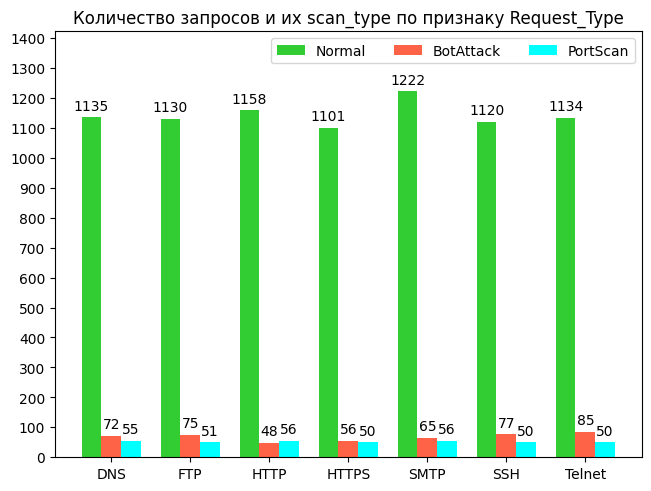

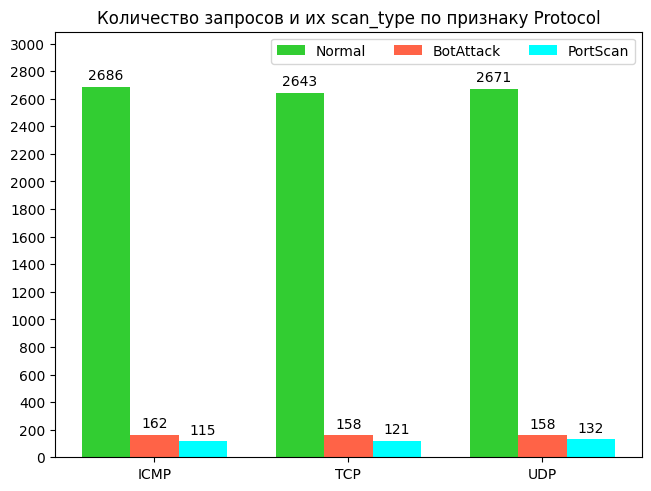

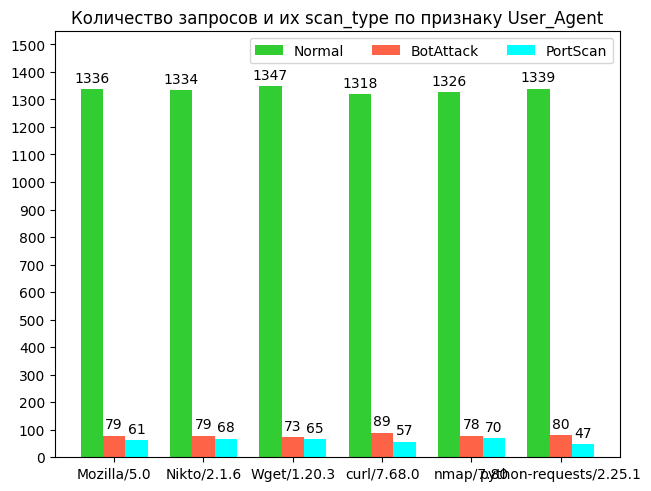

In [28]:
outcomes = ['Normal', 'BotAttack', 'PortScan']

for feature in list_of_features[1:]:
    request_by_scan_type, feature_labels = create_feature_dict(feature, outcomes) 
    create_bar_plot(request_by_scan_type, feature_labels, feature)

Все графики показывают приблизительно одинаковую картину: для всех признаков значение 'Normal' переменной Scan_Type имеет огромный перевес по сравнению со значениями 'BotAttack' и 'PortScan'. При этом все значения каждого признака находятся приблизительно на одном уровне для всех 'Normal' значений и 'BotAttack'/'PortScan'. Из этого следует вывод: **при Normal, BotAttack и PortScan нет явных фаворитов среди значений протоколов, портов и User-Agent'ов. Однако некоторые количественные отличия всё же присутствуют, поэтому данные признаки следует включить для обучения модели.**

### Проанализируем нагрузку

Построим гистограмму частот для визуализации размеров нагрузки с попытками вторжения.

Text(0, 0.5, 'Количество запросов')

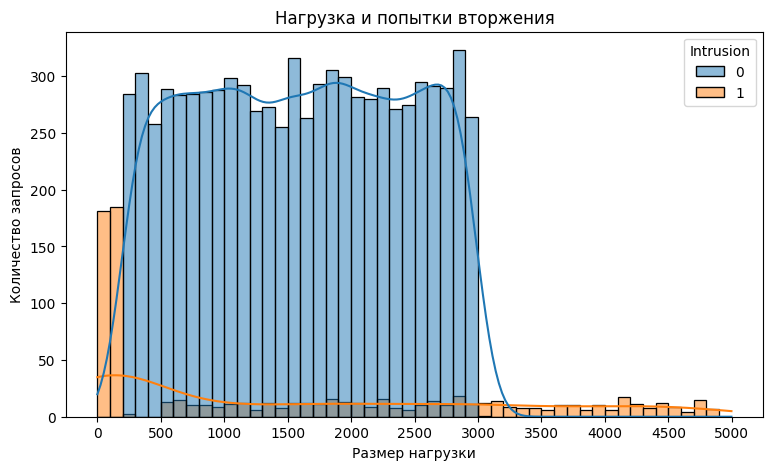

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 5))

sns.histplot(data=logs, x='Payload_Size', hue='Intrusion', bins=np.arange(0, np.max(logs['Payload_Size']), 100), kde=True, ax=ax)
ax.set_title('Нагрузка и попытки вторжения')
ax.set_xticks(np.arange(0, 5100, 500))
ax.set_xlabel('Размер нагрузки')
ax.set_ylabel('Количество запросов')

Что мы можем видеть на гистограмме:
- больше всего попыток вторжений при малом (<200) и при большом (>3000) размере нагрузки;
- начиная со значения размера нагрузки в 3000 ед. все запросы являются вредоносными.

Построим гистограмму частот для визуализации размеров нагрузки с типом запроса. Что мы можем видеть на гистограмме:
- больше всего запросов с малой нагрузкой относятся к сканированию портов (корреляция с признаком вторжения);
- начиная со значения размера нагрузки в 3000 ед. все запросы относятся к бот-атаке (так же корреляция с признаком вторжения).

Text(0, 0.5, 'Количество запросов')

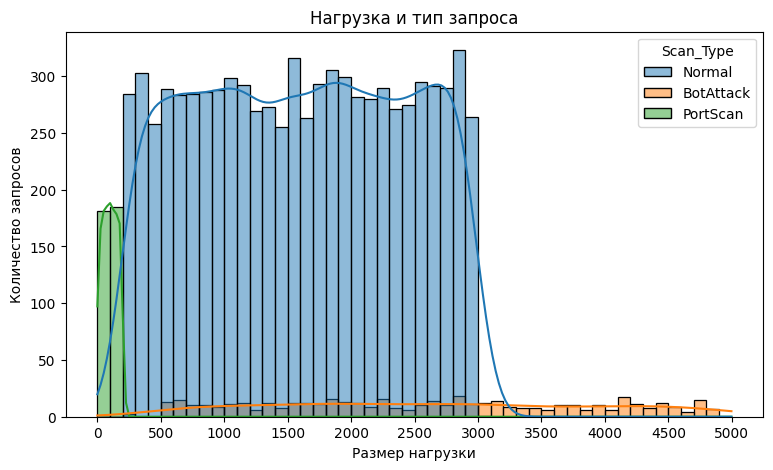

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 5))

sns.histplot(data=logs, x='Payload_Size', hue='Scan_Type', bins=np.arange(0, np.max(logs['Payload_Size']), 100), kde=True, ax=ax)
ax.set_title('Нагрузка и тип запроса')
ax.set_xticks(np.arange(0, 5100, 500))
ax.set_xlabel('Размер нагрузки')
ax.set_ylabel('Количество запросов')

## Создание и преобразование признаков

На этапе разведочного анализа данных было принято решение взять в качестве признаков следующие столбцы: Port, Request_Type, Protocol, Payload_Size, User-Agent, Status. Удалим столбцы Source_IP и Destination_IP из датафрейма, т.к. они не несут практической пользы, а также столбец Intrusion, чтобы избежать таргетную утечку данных, т.к. признак Intrusion говорит о факте атаки.

Заодно приведем все категориальные столбцы к одному типу - object - для дальнейшего их кодирования.

In [28]:
logs.drop(['Source_IP', 'Destination_IP', 'Intrusion'], axis=1, inplace=True)
logs['Port'] = logs['Port'].astype('object')

Во избежание утечки данных через их предобработку разделим выборку на обучающую и тестовую. При разделении выборки важно учесть выводы, сделанные на этапе EDA: данные не сбалансированы. Количество атак в выборке составляет чуть менее 10%, в то время как нормальных запросов 90%. Чтобы сохранить распределение классов необходимо использовать стратифицированную выборку.

In [29]:
X = logs.drop('Scan_Type', axis=1)
y = logs['Scan_Type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [30]:
print(f"Соотношение запросов по типу в тренировочном датасете в %:\n{y_train.value_counts().div(y_train.count()) * 100}")

Соотношение запросов по типу в тренировочном датасете в %:
Scan_Type
Normal       90.439276
BotAttack     5.394057
PortScan      4.166667
Name: count, dtype: float64


In [31]:
X_train['Port'].unique()

array([21, 80, 25, 22, 53, 31337, 443, 4444, 23, 6667, 8080, 135],
      dtype=object)

In [32]:
X_train.head()

,Port,Request_Type,Protocol,Payload_Size,User_Agent,Status
6201,21,DNS,UDP,1542,Nikto/2.1.6,Success
386,80,FTP,UDP,311,nmap/7.80,Success
6763,21,SSH,UDP,1579,curl/7.68.0,Success
8272,25,Telnet,ICMP,2178,nmap/7.80,Success
7671,25,HTTPS,ICMP,2188,python-requests/2.25.1,Success


In [33]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6192 entries, 6201 to 3467
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Port          6192 non-null   object
 1   Request_Type  6192 non-null   object
 2   Protocol      6192 non-null   object
 3   Payload_Size  6192 non-null   int64 
 4   User_Agent    6192 non-null   object
 5   Status        6192 non-null   object
dtypes: int64(1), object(5)
memory usage: 338.6+ KB


In [34]:
y_train.head()

6201    Normal
386     Normal
6763    Normal
8272    Normal
7671    Normal
Name: Scan_Type, dtype: object

## Дерево решений
### Преобразование категориальных признаков
Преобразуем категориальные признаки для дерева решений. Для этого я использую TargetEncoder и LabelEncoder из модуля preprocessing библиотеки scikit-learn. Столбцы Port, Request_Type, Protocol, User_Agent закодируем с помощью TargetEncoder'а,а столбец Status - с помощью LabelEncoder'а.

In [35]:
# Кодирование категориальных признаков с помощью TargetEncoder
categorical_features = ['Port', 'Request_Type', 'Protocol', 'User_Agent']

# объект класса TargetEncoder для мультиклассовой классификации, с авторегуляризацией и без перемешивания
target_encoder = TargetEncoder(target_type='multiclass', smooth='auto', shuffle=False)

X_train_cat = target_encoder.fit_transform(X_train[categorical_features], y_train)
X_test_cat = target_encoder.transform(X_test[categorical_features])

In [36]:
# Создание списка названий признаков
new_categories = []

for category in categorical_features:
    for scan_type in target_encoder.classes_:
        new_categories.append(f"{scan_type}_{category}")

In [37]:
# Добавление новых категориальных признаков в исходный датафрейм
X_train_cat_df = pd.DataFrame(
    X_train_cat, index=X_train.index, columns=new_categories
)

X_test_cat_df = pd.DataFrame(
    X_test_cat, index=X_test.index, columns=new_categories
)

X_train = pd.concat([X_train, X_train_cat_df], axis=1)
X_train.drop(categorical_features, axis=1, inplace=True)

X_test = pd.concat([X_test, X_test_cat_df], axis=1)
X_test.drop(categorical_features, axis=1, inplace=True)

In [38]:
X_train.head()

,Payload_Size,Status,BotAttack_Port,Normal_Port,PortScan_Port,BotAttack_Request_Type,Normal_Request_Type,PortScan_Request_Type,BotAttack_Protocol,Normal_Protocol,PortScan_Protocol,BotAttack_User_Agent,Normal_User_Agent,PortScan_User_Agent
6201,1542,Success,0.0,1.0,0.0,0.055005,0.899866,0.045129,0.058400,0.896906,0.044694,0.053270,0.903149,0.043581
386,311,Success,0.0,1.0,0.0,0.060461,0.901185,0.038353,0.058400,0.896906,0.044694,0.046714,0.904192,0.049091
6763,1579,Success,0.0,1.0,0.0,0.060819,0.891713,0.047468,0.058400,0.896906,0.044694,0.061264,0.900740,0.037994
8272,2178,Success,0.0,1.0,0.0,0.070450,0.897616,0.031925,0.053638,0.906904,0.039459,0.046714,0.904192,0.049091
7671,2188,Success,0.0,1.0,0.0,0.050450,0.910970,0.038580,0.053638,0.906904,0.039459,0.061717,0.904938,0.033342


In [39]:
# Кодирование признака Status с помощью LabelEncoder
le_encoder = LabelEncoder()

X_train['Status'] = le_encoder.fit_transform(X_train['Status'])
X_test['Status'] = le_encoder.transform(X_test['Status'])

In [40]:
X_train.head()

,Payload_Size,Status,BotAttack_Port,Normal_Port,PortScan_Port,BotAttack_Request_Type,Normal_Request_Type,PortScan_Request_Type,BotAttack_Protocol,Normal_Protocol,PortScan_Protocol,BotAttack_User_Agent,Normal_User_Agent,PortScan_User_Agent
6201,1542,1,0.0,1.0,0.0,0.055005,0.899866,0.045129,0.058400,0.896906,0.044694,0.053270,0.903149,0.043581
386,311,1,0.0,1.0,0.0,0.060461,0.901185,0.038353,0.058400,0.896906,0.044694,0.046714,0.904192,0.049091
6763,1579,1,0.0,1.0,0.0,0.060819,0.891713,0.047468,0.058400,0.896906,0.044694,0.061264,0.900740,0.037994
8272,2178,1,0.0,1.0,0.0,0.070450,0.897616,0.031925,0.053638,0.906904,0.039459,0.046714,0.904192,0.049091
7671,2188,1,0.0,1.0,0.0,0.050450,0.910970,0.038580,0.053638,0.906904,0.039459,0.061717,0.904938,0.033342


### Преобразование количественных признаков
Нормализуем значения нагрузки с помощью StandardScaler.

In [41]:
# Нормализация признака Payload_Size
scaler = StandardScaler()

X_train['Payload_Size'] = scaler.fit_transform(X_train[['Payload_Size']])
X_test['Payload_Size'] = scaler.transform(X_test[['Payload_Size']])

In [42]:
X_train.head()

,Payload_Size,Status,BotAttack_Port,Normal_Port,PortScan_Port,BotAttack_Request_Type,Normal_Request_Type,PortScan_Request_Type,BotAttack_Protocol,Normal_Protocol,PortScan_Protocol,BotAttack_User_Agent,Normal_User_Agent,PortScan_User_Agent
6201,-0.056298,1,0.0,1.0,0.0,0.055005,0.899866,0.045129,0.058400,0.896906,0.044694,0.053270,0.903149,0.043581
386,-1.396757,1,0.0,1.0,0.0,0.060461,0.901185,0.038353,0.058400,0.896906,0.044694,0.046714,0.904192,0.049091
6763,-0.016008,1,0.0,1.0,0.0,0.060819,0.891713,0.047468,0.058400,0.896906,0.044694,0.061264,0.900740,0.037994
8272,0.636254,1,0.0,1.0,0.0,0.070450,0.897616,0.031925,0.053638,0.906904,0.039459,0.046714,0.904192,0.049091
7671,0.647143,1,0.0,1.0,0.0,0.050450,0.910970,0.038580,0.053638,0.906904,0.039459,0.061717,0.904938,0.033342


In [43]:
X_test.head()

,Payload_Size,Status,BotAttack_Port,Normal_Port,PortScan_Port,BotAttack_Request_Type,Normal_Request_Type,PortScan_Request_Type,BotAttack_Protocol,Normal_Protocol,PortScan_Protocol,BotAttack_User_Agent,Normal_User_Agent,PortScan_User_Agent
4963,0.918283,1,0.000000,1.0,0.000000,0.058474,0.900589,0.040937,0.052581,0.906036,0.041383,0.050867,0.899237,0.049895
448,-0.548489,1,0.000000,1.0,0.000000,0.058474,0.900589,0.040937,0.052581,0.906036,0.041383,0.050867,0.899237,0.049895
146,-1.382601,1,0.000000,1.0,0.000000,0.060668,0.893829,0.045503,0.053476,0.906659,0.039865,0.050867,0.899237,0.049895
1746,0.749501,0,0.000000,1.0,0.000000,0.058474,0.900589,0.040937,0.053476,0.906659,0.039865,0.059046,0.903196,0.037758
3489,-1.566628,0,0.567052,0.0,0.386854,0.058474,0.900589,0.040937,0.055742,0.900531,0.043728,0.059046,0.903196,0.037758


Для дальнейшего удобства создадим функции для преобразования количественных и качественных признаков. 

In [3]:
def dataset_splitting(data):
    """Функция для разделения датасета на тренировочную и тестовую выборки"""
    
    columns_to_drop = ['Source_IP', 'Destination_IP', 'Intrusion']
    
    # Удаление лишних столбцов и приведение признака Port к типу object 
    data = data.drop(columns_to_drop, axis=1)
    data['Port'] = data['Port'].astype('object')
    
    X = data.drop('Scan_Type', axis=1)
    y = data['Scan_Type']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    
    return X_train, X_test, y_train, y_test


def categorical_data_preprocessing(X_train, X_test, y_train):
    """Функция для преобразования качественных признаков"""
    
    # Кодирование категориальных признаков с помощью TargetEncoder
    categorical_features = ['Port', 'Request_Type', 'Protocol', 'User_Agent']
    
    # объект класса TargetEncoder для мультиклассовой классификации, с авторегуляризацией и без перемешивания
    target_encoder = TargetEncoder(target_type='multiclass', smooth='auto', shuffle=False)
    
    X_train_cat = target_encoder.fit_transform(X_train[categorical_features], y_train)
    X_test_cat = target_encoder.transform(X_test[categorical_features])
    
    # Создание списка названий признаков
    new_categories = []

    for category in categorical_features:
        for scan_type in target_encoder.classes_:
            new_categories.append(f"{scan_type}_{category}")
            
    # Добавление новых категориальных признаков в исходный датафрейм
    X_train_cat_df = pd.DataFrame(
        X_train_cat, index=X_train.index, columns=new_categories
    )

    X_test_cat_df = pd.DataFrame(
        X_test_cat, index=X_test.index, columns=new_categories
    )
    
    X_train = pd.concat([X_train, X_train_cat_df], axis=1)
    X_train = X_train.drop(categorical_features, axis=1)

    X_test = pd.concat([X_test, X_test_cat_df], axis=1)
    X_test = X_test.drop(categorical_features, axis=1)
    
    # Кодирование признака Status с помощью LabelEncoder
    le_encoder = LabelEncoder()

    X_train['Status'] = le_encoder.fit_transform(X_train['Status'])
    X_test['Status'] = le_encoder.transform(X_test['Status'])
    
    return X_train, X_test


def quantitive_data_preprocessing(X_train, X_test):
    """Функция для преобразования количественных признаков"""
    
    # Нормализация признака Payload_Size
    scaler = StandardScaler()

    X_train['Payload_Size'] = scaler.fit_transform(X_train[['Payload_Size']])
    X_test['Payload_Size'] = scaler.transform(X_test[['Payload_Size']])
    
    return X_train, X_test

      Payload_Size  Status  BotAttack_Port  Normal_Port  PortScan_Port  \
6201     -0.056298       1             0.0          1.0            0.0   
386      -1.396757       1             0.0          1.0            0.0   
6763     -0.016008       1             0.0          1.0            0.0   
8272      0.636254       1             0.0          1.0            0.0   
7671      0.647143       1             0.0          1.0            0.0   

      BotAttack_Request_Type  Normal_Request_Type  PortScan_Request_Type  \
6201                0.055005             0.899866               0.045129   
386                 0.060461             0.901185               0.038353   
6763                0.060819             0.891713               0.047468   
8272                0.070450             0.897616               0.031925   
7671                0.050450             0.910970               0.038580   

      BotAttack_Protocol  Normal_Protocol  PortScan_Protocol  \
6201            0.058400         0

In [ ]:
X_train, X_test, y_train, y_test = dataset_splitting(logs)
X_train, X_test = categorical_data_preprocessing(X_train, X_test, y_train)
X_train, X_test = quantitive_data_preprocessing(X_train, X_test)

print(X_train.head())
print(X_test.head())

## Обучение модели дерева решений

In [4]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [5]:
y_pred = model.predict(X_test)

## Оценка эффективности модели
Выберем среди метрик качества моделей классификации наиболее подходящие:

- Accuracy (Общая точность) - доля правильных предсказаний среди всех наблюдений: (TP+TN)/(TP+FP+TN+FN). В данном случае ориентироваться на Accuracy не стоит, т.к. имеется явный дисбаланс классов Normal и BotAttack/PortScan.
- Precision (Точность) - доля правильно предсказанных положительных результатов среди всех положительных предсказаний: TP/(TP+FP). В данном случае метрика Precision важна для определения истинных типов атак.
- Recall (Плотность) - доля правильно предсказанных положительных результатов из всех фактически положительных: TP/(TP+FN). В данном случае метрика Recall важна для охвата как можно большего количества вредоносных событий
- F1-score - гармоническое среднее между precision и recall, обеспечивающее баланс между этими метриками: 2(Precision\Recall)/(Precision+Recall). Так как важны и точность, и плотность при классификации, ориентиром будет метрика F1-Score

**В данном случае приоритетной метрикой я считаю F1-Score, т.к. я хочу добиться баланса между precision и recall. Остальные метрики будут выведены для наглядности.

In [6]:
print(f"Accuracy score: {accuracy_score(y_test, y_pred)}\n")
print(f"{classification_report(y_test, y_pred)}")

Accuracy score: 1.0

              precision    recall  f1-score   support

   BotAttack       1.00      1.00      1.00       144
      Normal       1.00      1.00      1.00      2400
    PortScan       1.00      1.00      1.00       110

    accuracy                           1.00      2654
   macro avg       1.00      1.00      1.00      2654
weighted avg       1.00      1.00      1.00      2654



Видно, что метрики эффективности модели имеют идеальные значения, что может говорить о переобучении модели. Выведем матрицу ошибок.

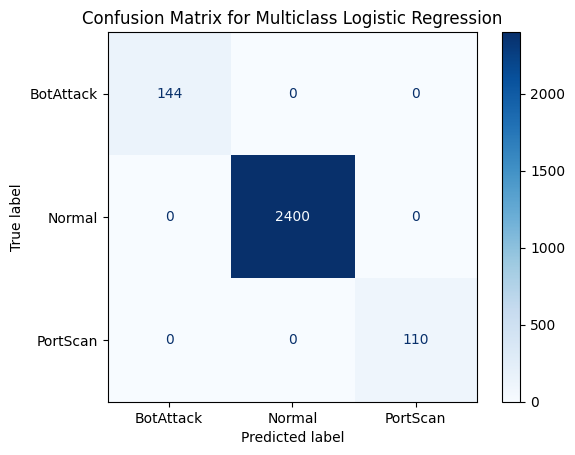

In [7]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
plt.title('Confusion Matrix for Multiclass Logistic Regression')
plt.show()

На матрице ошибок видно, что ошибок-то и нет. Такие показатели метрик модели могут говорить о переобучении, поэтому попробуем увеличить размер выборки и избавиться от дисбаланса классов с помощью SMOTE.

In [16]:
logs = pd.read_csv("Network_logs.csv")  # Повторная загрузка данных
X_train, X_test, y_train, y_test = dataset_splitting(logs)  # Разделение на тренировочную и тестовую выборки
X_train, X_test = categorical_data_preprocessing(X_train, X_test, y_train)  # Преобразование категориальных признаков
X_train, X_test = quantitive_data_preprocessing(X_train, X_test)  # Преобразование количественных признаков

In [17]:
smote = SMOTE(sampling_strategy='not majority', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

Выведем соотношение классов Scan_Type после применения SMOTE.

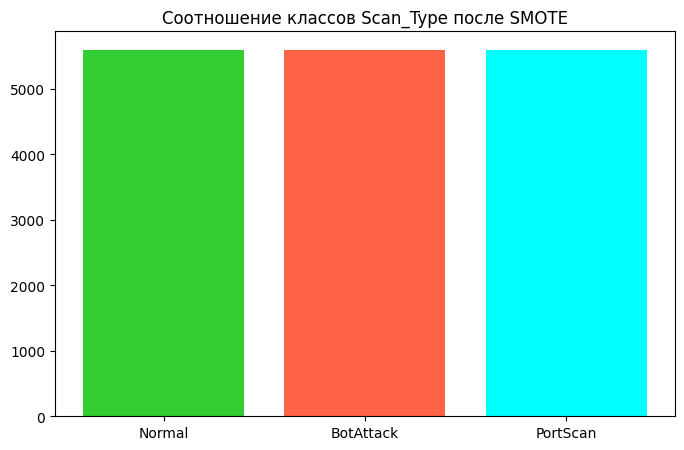

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.bar(y_train_smote.value_counts().index, y_train_smote.value_counts(), color=['limegreen', 'tomato', 'cyan'])
ax.set_title('Соотношение классов Scan_Type после SMOTE')
plt.show()

In [20]:
model2 = DecisionTreeClassifier()
model2.fit(X_train_smote, y_train_smote)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


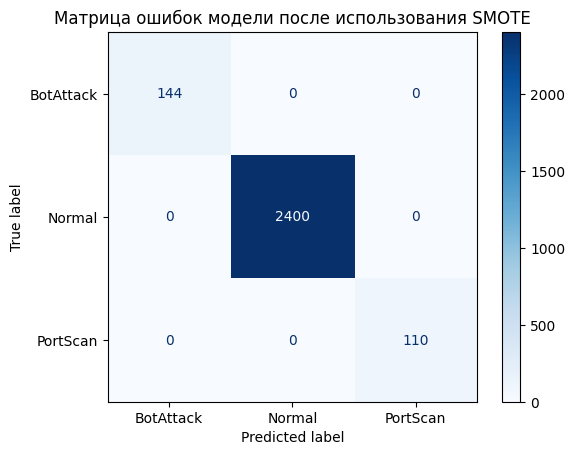

In [23]:
ConfusionMatrixDisplay.from_estimator(model2, X_test, y_test, cmap='Blues')
plt.title('Матрица ошибок модели после использования SMOTE')
plt.show()

## Вывод

Данная работа заключалась в классификации запросов в логах IDS на 3 класса:

- Normal - обычные запросы;
- BotAttack - бот-атака;
- PortScan - сканирование портов.

Данные не нуждались в очистке, т.к. среди записей пропущенных значений не обнаружено, среди числовых переменных выбросов не наблюдалось.

На этапе разведочного анализа данных (EDA) выяснилось, что:

- Столбцы с IP-адресами отправителя/получателя не имеют практической ценности, т.к. их значение не говорит о характере запроса;
- Столбец Intrusion напрямую связан с целевой переменной Scan_Type, т.к. заранее классифицирует запросы на нормальные и вредоносные. Во избежание таргетной утечки данных параметр был удалён;
- Какого-либо перевеса портов, протоколов или User-Agent'ов при нормальных и вредоносных запросах не наблюдалось;
- Столбец с нагрузкой имел различия при нормальных и вредоносных запросах.

На этапе создания и преобразования признаков (Feature Engineering):

- Был выбран TargetEncoder для кодирования признаков Port, Request_Type, Protocol и User-Agent, чтобы не вносить мнимый порядок, который может повлиять на качество модели, как с LabelEncoder и не плодить огромное число столбцов, как с One-Hot-Encoder;
- Был выбран LabelEncoder для кодирования признака Status, т.к. он является бинарным;
- Признак Payload_Size был нормализован с помощью StandardScaler.

В качестве алгоритма классификации в этой версии был выбран алгоритм дерева решений. В рузельтате тестирования модели были получены следующие метрики:

Accuracy: 1 (Не ориентир из-за дисбаланса классов)
Precision (macro avg): 1
Recall (macro avg): 1
F1-score (macro avg): 1

Высокие показатели метрик могут говорить о переобучении модели. Для того, чтобы получить более реальные показатели метрик я увеличил исходную выборку и убрал дисбаланс классов с помощью SMOTE. Однако метрики остались на том же высоком уровне. Из этого я делаю следующий вывод: **Хотя метрики модели классификации имеют высокие значения (модель не ошибается вовсе), нельзя говорить о безупречной работе модели в связи с малым количеством данных. Можно сказать, что модель хорошо обобщает текущие данные, однако использование реальных данных приведет к меньшим значениям метрик.**